# Данные

Данные предоставлены компанией [Home Credit](http://www.homecredit.net/about-us.aspx), которая занимается предоставлением кредитных линий (займов) для населения, не имеющего доступа к банковским услугам. Прогнозирование того, сможет ли клиент вернуть кредит или столкнется с трудностями, является критически важной задачей для бизнеса, и Home Credit проводит это соревнование на Kaggle, чтобы увидеть, какие модели может разработать сообщество специалистов по машинному обучению для решения этой задачи.

Существует 7 различных источников данных:

* `application_train`/`application_test`: основные обучающие и тестовые данные с информацией о каждой заявке на кредит в Home Credit. Каждая заявка представлена отдельной строкой и идентифицируется с помощью признака `SK_ID_CURR`. В обучающих данных есть метка `TARGET`, где 0 означает, что кредит был возвращен, а 1 — что кредит не был возвращен.
* `bureau`: данные о предыдущих кредитах клиента в других финансовых учреждениях. Каждый предыдущий кредит представлен отдельной строкой в `bureau`, но одна заявка в данных может иметь несколько предыдущих кредитов.
* `bureau_balance`: ежемесячные данные о предыдущих кредитах из `bureau`. Каждая строка представляет один месяц предыдущего кредита, и один кредит может иметь несколько строк, по одной на каждый месяц срока кредита.
* `previous_application`: данные о предыдущих заявках на кредиты в Home Credit для клиентов, которые имеют кредиты в текущих данных. Каждая текущая заявка может иметь несколько предыдущих заявок. Каждая предыдущая заявка представлена отдельной строкой и идентифицируется с помощью признака `SK_ID_PREV`.
* `POS_CASH_BALANCE`: ежемесячные данные о предыдущих кредитах на покупку в точках продаж или наличных кредитах, которые клиенты брали в Home Credit. Каждая строка представляет один месяц предыдущего кредита, и один кредит может иметь множество строк.
* `credit_card_balance`: ежемесячные данные о предыдущих кредитных картах, которые клиенты имели в Home Credit. Каждая строка представляет один месяц баланса кредитной карты, и одна карта может иметь множество строк.
* `installments_payment`: история платежей по предыдущим кредитам в Home Credit. Каждая строка представляет один произведенный платеж или один пропущенный платеж.

Эта диаграмма показывает, как связаны все данные:

![image](https://storage.googleapis.com/kaggle-media/competitions/home-credit/home_credit.png)

Кроме того, нам предоставлены определения всех столбцов (в файле `HomeCredit_columns_description.csv`) и пример ожидаемого файла для отправки.

# Данные

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import numpy as np

from scipy.stats import bootstrap
from sklearn.metrics import roc_auc_score

In [2]:
# Описание данных
data_descr = pd.read_csv('./HomeCredit_columns_description.csv', index_col=0)
data_descr

,Table,Row,Description,Special
index,,,,
1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
2,application_{train|test}.csv,TARGET,Target variable (1 - client with payment diffi...,NaN
5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN
...,...,...,...,...
217,installments_payments.csv,NUM_INSTALMENT_NUMBER,On which installment we observe payment,NaN
218,installments_payments.csv,DAYS_INSTALMENT,When the installment of previous credit was su...,time only relative to the application
219,installments_payments.csv,DAYS_ENTRY_PAYMENT,When was the installments of previous credit p...,time only relative to the application


In [3]:
# Training data
app_train = pd.read_csv('application_train.csv')
print('Training data shape: ', app_train.shape)
app_train.head()

Training data shape:  (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


The training data has 307511 observations (each one a separate loan) and 122 features (variables) including the `TARGET` (the label we want to predict).

In [4]:
# Testing data features
app_test = pd.read_csv('application_test.csv')
print('Testing data shape: ', app_test.shape)
app_test.head()

Testing data shape:  (48744, 121)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
bureau_balance = pd.read_csv('bureau_balance.csv')
print('Testing data shape: ', bureau_balance.shape)
bureau_balance.head()

Testing data shape:  (27299925, 3)


,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [6]:
bureau = pd.read_csv('bureau.csv')#.rename(columns={'SK_ID_CURR':'SK_ID_CURR_bureau'})
print('Testing data shape: ', bureau.shape)
bureau.head()

Testing data shape:  (1716428, 17)


,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [7]:
credic_card_balance = pd.read_csv('./credit_card_balance.csv')
print('Testing data shape: ', credic_card_balance.shape)
credic_card_balance.head()

Testing data shape:  (3840312, 23)


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


In [8]:
previous_application = pd.read_csv('./previous_application.csv')#.rename(columns={'SK_ID_CURR':'SK_ID_CURR_PA'})
print('Testing data shape: ', previous_application.shape)
previous_application.head()

Testing data shape:  (1670214, 37)


,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


## EDA

### Аномалии

In [10]:
app_train['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

In [26]:
data_descr.query('Row == "DAYS_EMPLOYED"')['Description'].values

array(['How many days before the application the person started current employment'],
      dtype=object)

Согласно описанию, `DAYS_EMPOYMENT` – это стаж работы (в днях) клиента на момент взятия кредита. По какой-то причине все данные идут с отрицательным значением, но есть небольшая часть, в которой значение положительное и составлеят 1000 лет.

Text(0.5, 0, 'Days Employment')

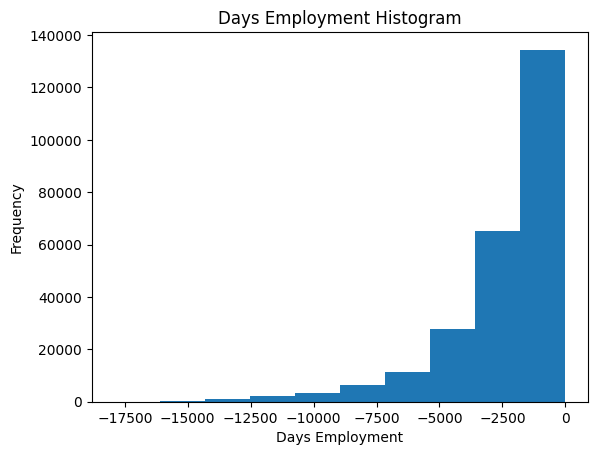

In [27]:
app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment')

Кроме значения 365243 больше нет других положительных значений. Это явная аномалия, от которой нужно избавиться

In [28]:
anom = app_train[app_train['DAYS_EMPLOYED'] == 365243]
non_anom = app_train[app_train['DAYS_EMPLOYED'] != 365243]
print('Среднее значение таргета на неаномальных данных %0.5f' % (non_anom['TARGET'].mean()))
print('Среднее значение таргета на аномальных данных %0.5f' % (anom['TARGET'].mean()))
print('Количество аномальных данных: %d' % len(anom))

Среднее значение таргета на неаномальных данных 0.08073
Среднее значение таргета на аномальных данных nan
Количество аномальных данных: 0


Видно, что среднее значение таргета на аномальных данных ниже, чем у остальных. 

Заменим все аномальные данные на `np.nan` значения (которые похже можно будет заменить на медианное значение) и создадим новую фичу-флаг, которая будет обозначать аномальные данные

C:\Users\nikit\AppData\Local\Temp\ipykernel_23108\740810909.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)


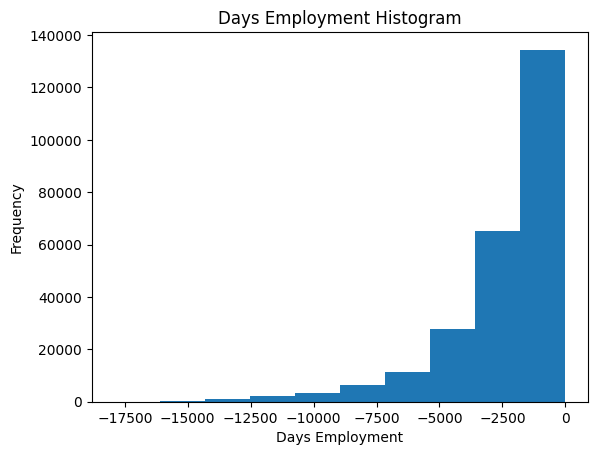

In [18]:
# Create an anomalous flag column
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243

# Replace the anomalous values with nan
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

После исключения аномальных данных, распределение стажа больше похоже на, что мы ожидаем увидеть в реальной жизни

### Корреляции

Датасет предоставляет очень много фичей. Уделить должно внимание всем не удасться, поэтому будем смотреть на самые коррелирующие

In [ ]:
# Find correlations with the target and sort
correlations = app_train.corr()['TARGET'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 OCCUPATION_TYPE_Laborers                             0.043019
FLAG_DOCUMENT_3                                      0.044346
REG_CITY_NOT_LIVE_CITY                               0.044395
FLAG_EMP_PHONE                                       0.045982
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
REG_CITY_NOT_WORK_CITY                               0.050994
DAYS_ID_PUBLISH                                      0.051457
CODE_GENDER_M                                        0.054713
DAYS_LAST_PHONE_CHANGE                               0.055218
NAME_INCOME_TYPE_Working                             0.057481
REGION_RATING_CLIENT                                 0.058899
REGION_RATING_CLIENT_W_CITY                          0.060893
DAYS_EMPLOYED                                        0.074958
DAYS_BIRTH                                           0.078239
TARGET                                               1.000000
Name: TARGET, dtype: float64

Most Negati

Самой большой корреляцией с таргетом обладает `DAYS_BIRTH`. Согласно описанию, это поле означает возраст в днях на момент взятия кредита, но со знаком минус. То есть, чем больше значение `DAYS_BIRTH` (т.е. меньше возраст), тем больше значение таргета (выше количество должников). Проверим это 

In [29]:
# Find the correlation of the positive days since birth and target
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])
app_train['DAYS_BIRTH'].corr(app_train['TARGET'])

-0.07823930830982691

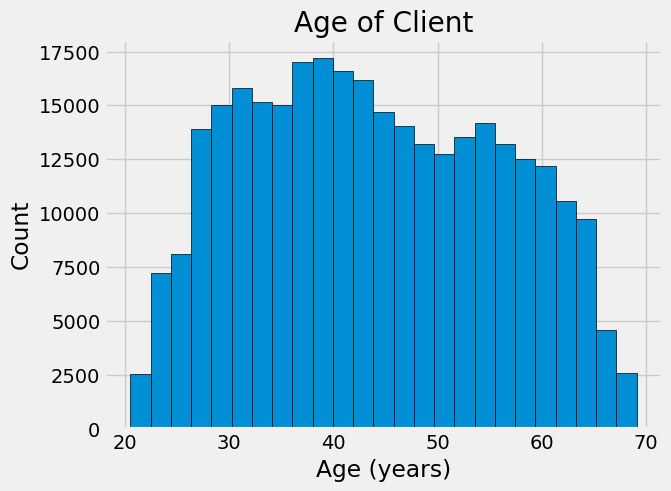

In [30]:
# Set the style of plots
plt.style.use('fivethirtyeight')

# Plot the distribution of ages in years
plt.hist(app_train['DAYS_BIRTH'] / 365, edgecolor = 'k', bins = 25)
plt.title('Age of Client'); plt.xlabel('Age (years)'); plt.ylabel('Count');

Распределение возрастов выглядит почти равномерным, с небольшим перевесом для возрастов от 35 до 45.
Посмотрим на распределения возрастов для каждого класса таргета

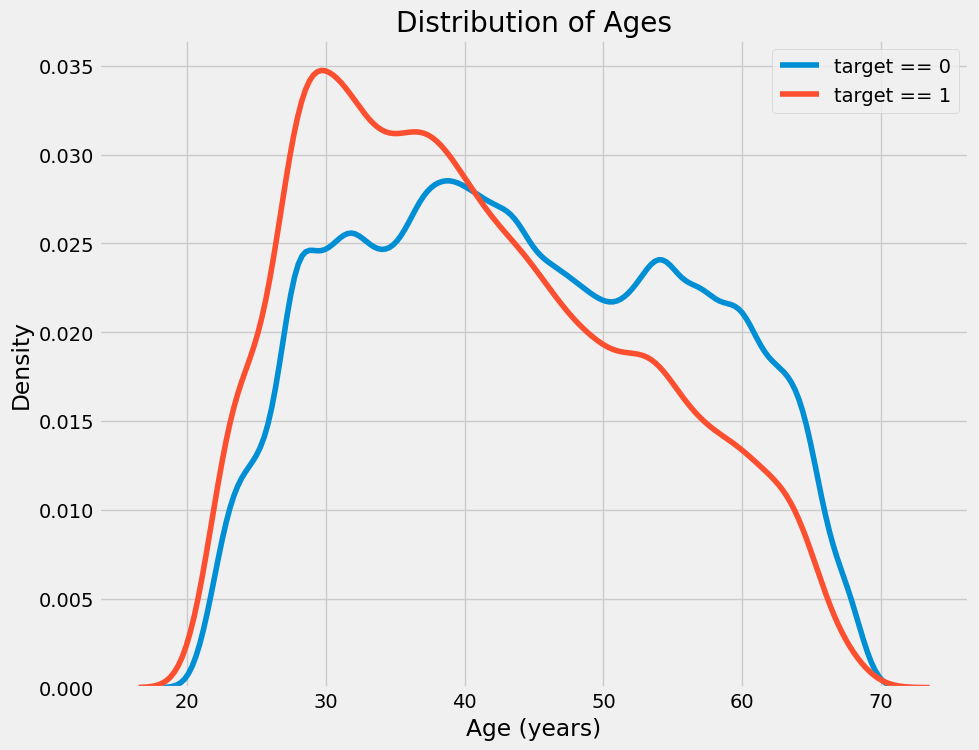

In [39]:
plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1')

# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages')
plt.legend()

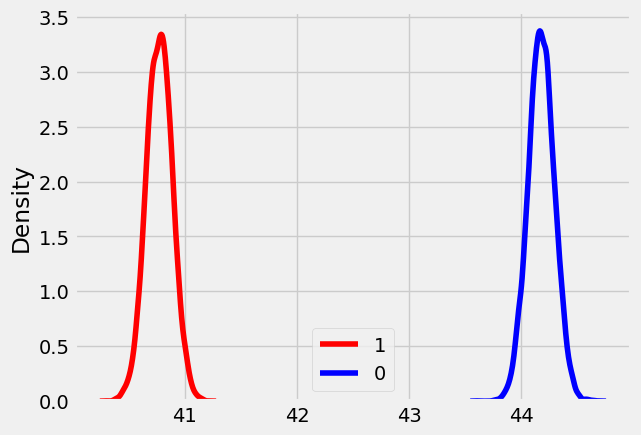

In [38]:
mask = app_train['TARGET'] == 1

A = (app_train['DAYS_BIRTH'] / 365)[mask].to_numpy()[:10000]
B = (app_train['DAYS_BIRTH'] / 365)[~mask].to_numpy()[:10000]

A = bootstrap((A,), np.mean, batch=100)
B = bootstrap((B,), np.mean, batch=100)

sns.kdeplot(A.bootstrap_distribution, label='1', c='r')
sns.kdeplot(B.bootstrap_distribution, label='0', c='b')
plt.legend()

Распределения возраста для обоих классов действительно различаются. Для класса 0 (недолжников) распределение возраста более равномерное, а для класса 1 (должников) значительно преобладает молодое поколение.

Разделим данные по бинам в 5 лет и посмотрим, как меняется относительное количество должников в каждом бине

In [40]:
# Age information into a separate dataframe
age_data = app_train[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# Bin the age data
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
age_data.head(10)

C:\Users\nikit\AppData\Local\Temp\ipykernel_23108\1136001900.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365
C:\Users\nikit\AppData\Local\Temp\ipykernel_23108\1136001900.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))


,TARGET,DAYS_BIRTH,YEARS_BIRTH,YEARS_BINNED
0,1,9461,25.920548,"(25.0, 30.0]"
1,0,16765,45.931507,"(45.0, 50.0]"
2,0,19046,52.180822,"(50.0, 55.0]"
3,0,19005,52.068493,"(50.0, 55.0]"
4,0,19932,54.608219,"(50.0, 55.0]"
5,0,16941,46.413699,"(45.0, 50.0]"
6,0,13778,37.747945,"(35.0, 40.0]"
7,0,18850,51.643836,"(50.0, 55.0]"
8,0,20099,55.065753,"(55.0, 60.0]"
9,0,14469,39.641096,"(35.0, 40.0]"


In [41]:
# Group by the bin and calculate averages
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

C:\Users\nikit\AppData\Local\Temp\ipykernel_23108\1757995694.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_groups  = age_data.groupby('YEARS_BINNED').mean()


,TARGET,DAYS_BIRTH,YEARS_BIRTH
YEARS_BINNED,,,
"(20.0, 25.0]",0.123036,8532.795625,23.377522
"(25.0, 30.0]",0.111436,10155.219250,27.822518
"(30.0, 35.0]",0.102814,11854.848377,32.479037
"(35.0, 40.0]",0.089414,13707.908253,37.555913
"(40.0, 45.0]",0.078491,15497.661233,42.459346
"(45.0, 50.0]",0.074171,17323.900441,47.462741
"(50.0, 55.0]",0.066968,19196.494791,52.593136
"(55.0, 60.0]",0.055314,20984.262742,57.491131
"(60.0, 65.0]",0.052737,22780.547460,62.412459


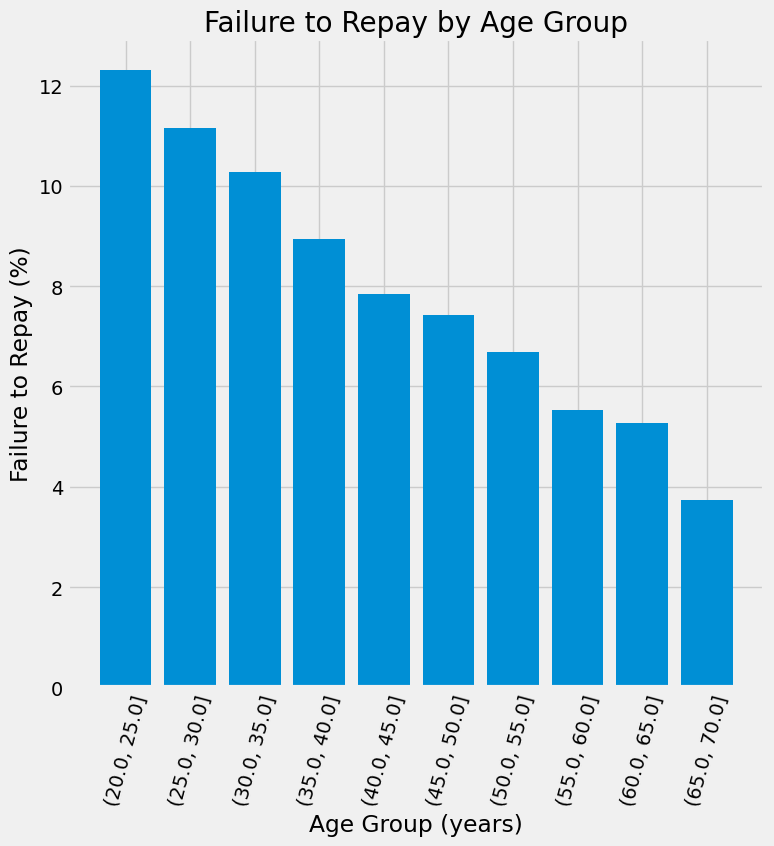

In [42]:
plt.figure(figsize = (8, 8))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group');

Очевидно, что с ростом возраста среднее количество должников падает. Хоть разница между самыми молодыми и самыми старыми весьма мала (12% против 3%), зависимость прослеживается четко, что может помочь модели в предсказании.

### Внешние фичи (`EXT_SOURCE`)

В датасете есть три фичи: `EXT_SOURCE_1`, `EXT_SOURCE_2`, and `EXT_SOURCE_3`. Эти фичи имели самую высокую (по модулю) отрицательную корреляцию с таргетом. 
Согласно документации, это "нормализированный скор из внешнего источника". Мы не знаем, на основе чего расчитывался этот скор

In [43]:
# Extract the EXT_SOURCE variables and show correlations
ext_data = app_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH
TARGET,1.000000,-0.155317,-0.160472,-0.178919,-0.078239
EXT_SOURCE_1,-0.155317,1.000000,0.213982,0.186846,0.600610
EXT_SOURCE_2,-0.160472,0.213982,1.000000,0.109167,0.091996
EXT_SOURCE_3,-0.178919,0.186846,0.109167,1.000000,0.205478
DAYS_BIRTH,-0.078239,0.600610,0.091996,0.205478,1.000000


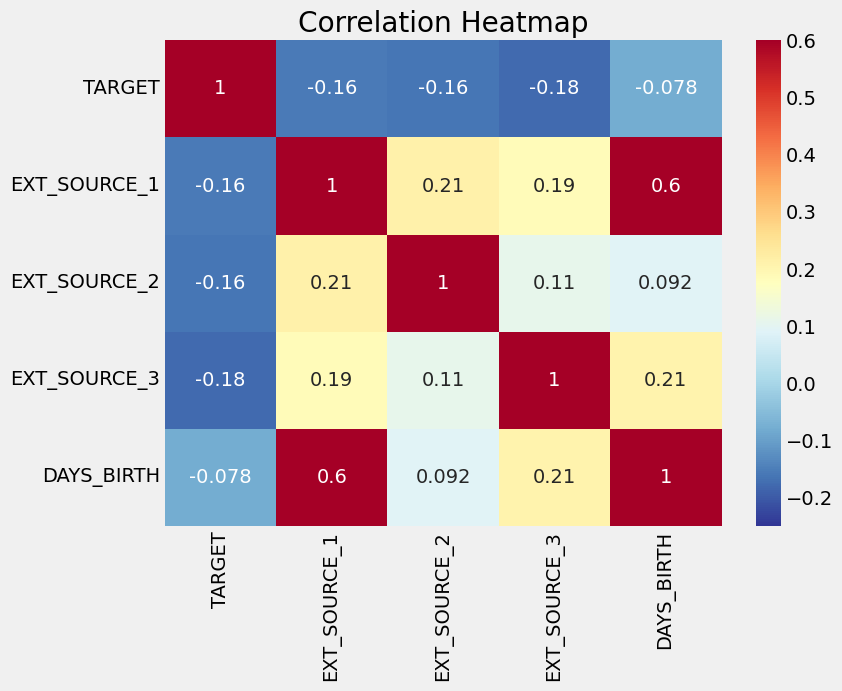

In [44]:
plt.figure(figsize = (8, 6))

# Heatmap of correlations
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');

Мы видим, что все три фичи слабо коррелируют с таргетом, но сильнее коррелируют между собой. На удивление, одна из фичей имеет весьма сильную корреляцию с `DAYS_BIRTH`, что может говорить о том, что для расчета этой фичи мог быть использован возраст.

Посмотрим на распрелеление каждой фичи для каждого класса

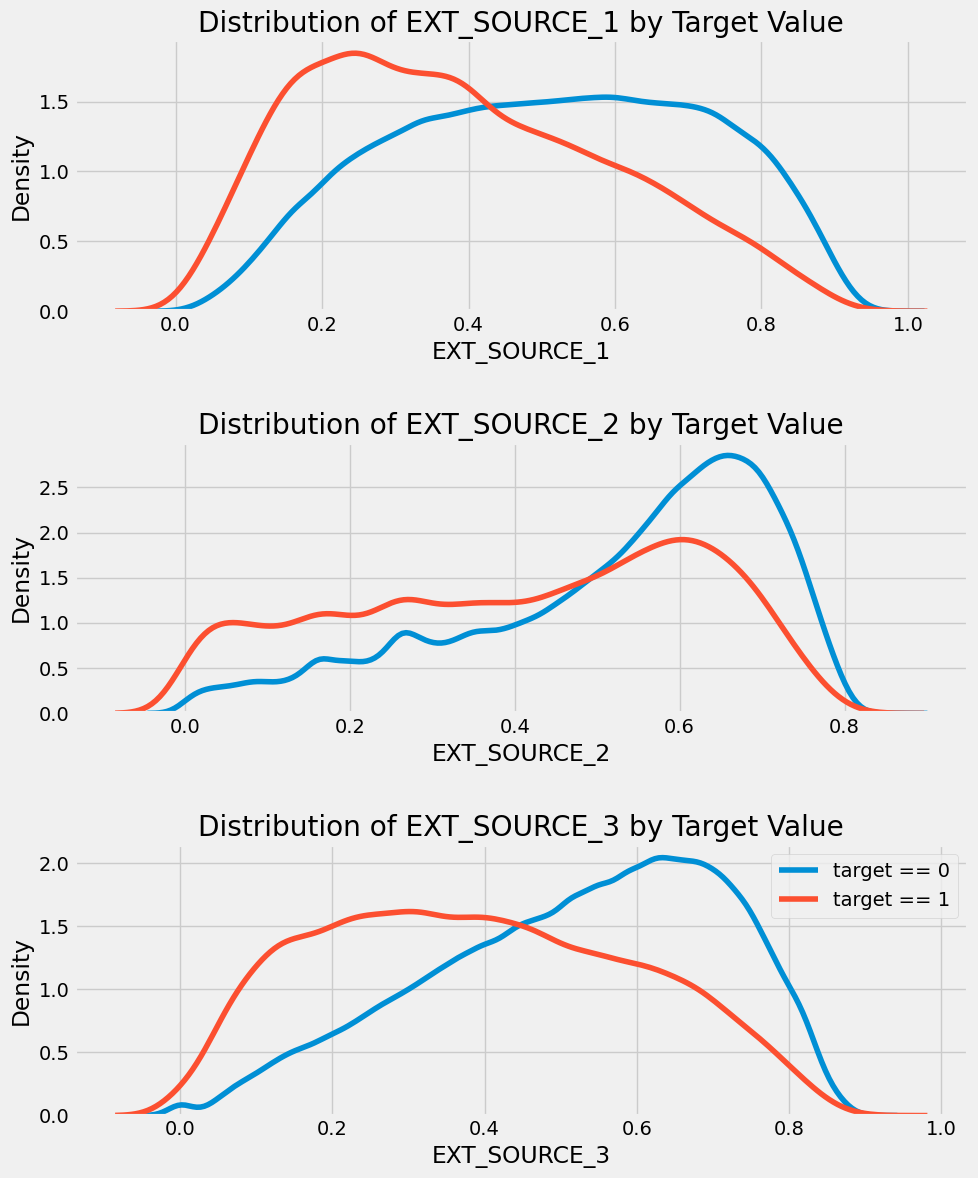

In [ ]:
plt.figure(figsize = (10, 12))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
    # create a new subplot for each source
    plt.subplot(3, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, source], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, source], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)
plt.legend()

Как и в ситуации с возрастом, мы видим, что распределения `EXT_SOURCE_3` для разных классов отличаются. Это может помочь модели в классификации.

### Pairs Plot

Построим графики для попарного сравнения всех `EXT_SOURCE_*` и `DAYS_BIRTH` между собой.

c:\Users\nikit\Desktop\Учеба\ИТМО\AutoML\.venv\lib\site-packages\seaborn\distributions.py:1128: UserWarning: cmap parameter ignored when using hue mapping.
  warnings.warn(msg, UserWarning)
c:\Users\nikit\Desktop\Учеба\ИТМО\AutoML\.venv\lib\site-packages\seaborn\distributions.py:1128: UserWarning: cmap parameter ignored when using hue mapping.
  warnings.warn(msg, UserWarning)
c:\Users\nikit\Desktop\Учеба\ИТМО\AutoML\.venv\lib\site-packages\seaborn\distributions.py:1128: UserWarning: cmap parameter ignored when using hue mapping.
  warnings.warn(msg, UserWarning)
c:\Users\nikit\Desktop\Учеба\ИТМО\AutoML\.venv\lib\site-packages\seaborn\distributions.py:1128: UserWarning: cmap parameter ignored when using hue mapping.
  warnings.warn(msg, UserWarning)
c:\Users\nikit\Desktop\Учеба\ИТМО\AutoML\.venv\lib\site-packages\seaborn\distributions.py:1128: UserWarning: cmap parameter ignored when using hue mapping.
  warnings.warn(msg, UserWarning)
c:\Users\nikit\Desktop\Учеба\ИТМО\AutoML\.venv\lib

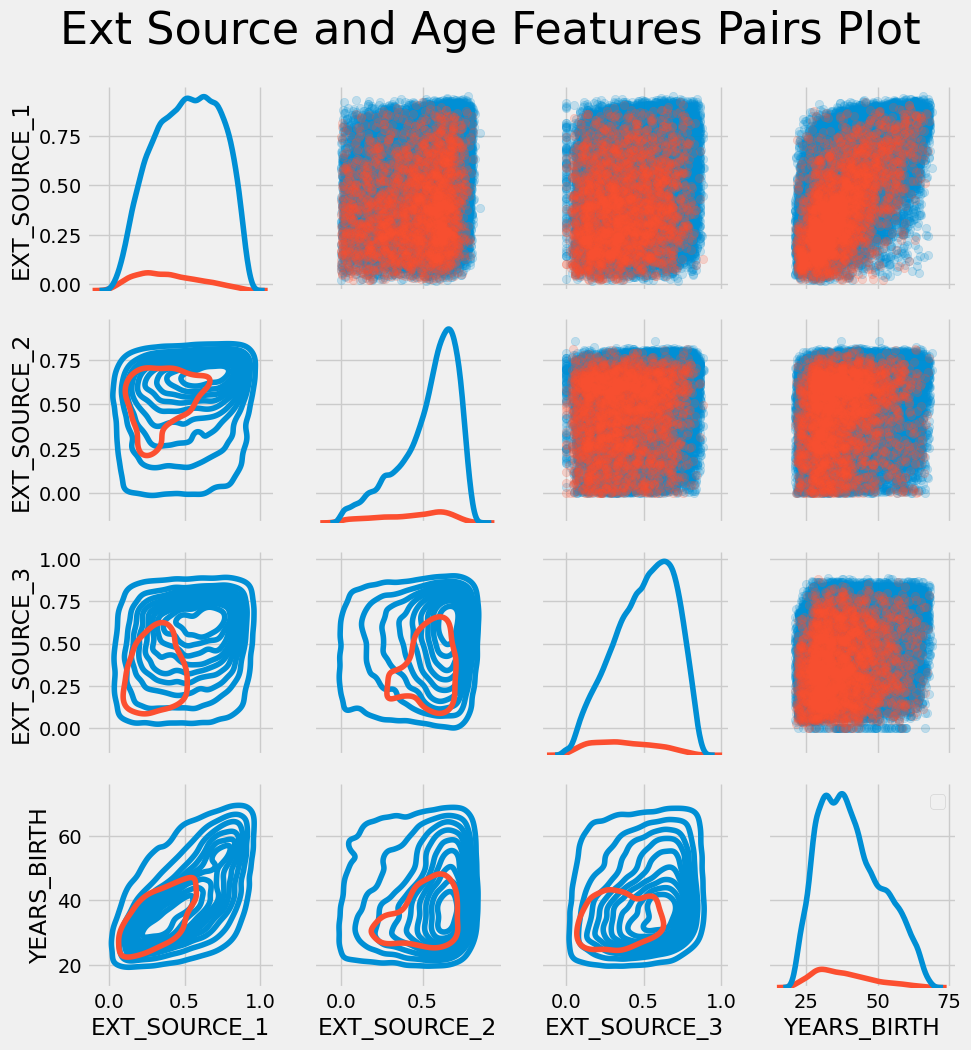

In [47]:
# Copy the data for plotting
plot_data = ext_data.drop(columns = ['DAYS_BIRTH']).copy()

# Add in the age of the client in years
plot_data['YEARS_BIRTH'] = age_data['YEARS_BIRTH']

# Drop na values and limit to first 100000 rows
plot_data = plot_data.dropna().loc[:100000, :]

# Function to calculate correlation coefficient between two columns
def corr_func(x, y, **kwargs):
    r = np.corrcoef(x, y)[0][1]
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.2, .8), xycoords=ax.transAxes,
                size = 20)

# Create the pairgrid object
grid = sns.PairGrid(data = plot_data, diag_sharey=False,
                    hue = 'TARGET', 
                    vars = [x for x in list(plot_data.columns) if x != 'TARGET'])

# Upper is a scatter plot
grid.map_upper(plt.scatter, alpha = 0.2)

# Diagonal is a histogram
grid.map_diag(sns.kdeplot)

# Bottom is density plot
grid.map_lower(sns.kdeplot, cmap = plt.cm.OrRd_r)

plt.suptitle('Ext Source and Age Features Pairs Plot', size = 32, y = 1.05)
plt.legend()

## Feature Engineering


### Polynomial Features

Сгенерируем полиноминальные фичи на основании `EXT_SOURCE_*` и `DAYS_BIRTH`.

In [ ]:
# Make a new dataframe for polynomial features
poly_features = app_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'TARGET']]
poly_features_test = app_test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]

# imputer for handling missing values
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy = 'median')

poly_target = poly_features['TARGET']

poly_features = poly_features.drop(columns = ['TARGET'])

# Need to impute missing values
poly_features = imputer.fit_transform(poly_features)
poly_features_test = imputer.transform(poly_features_test)

from sklearn.preprocessing import PolynomialFeatures
                                  
# Create the polynomial object with specified degree
poly_transformer = PolynomialFeatures(degree = 3)

In [50]:
# Train the polynomial features
poly_transformer.fit(poly_features)

# Transform the features
poly_features = poly_transformer.transform(poly_features)
poly_features_test = poly_transformer.transform(poly_features_test)
print('Polynomial Features shape: ', poly_features.shape)

Polynomial Features shape:  (307511, 35)


Мы получили 30 новых фичей (без учета 1 и изначальных фичей)

In [51]:
poly_transformer.get_feature_names_out(input_features = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH'])[:15]

array(['1', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH',
       'EXT_SOURCE_1^2', 'EXT_SOURCE_1 EXT_SOURCE_2',
       'EXT_SOURCE_1 EXT_SOURCE_3', 'EXT_SOURCE_1 DAYS_BIRTH',
       'EXT_SOURCE_2^2', 'EXT_SOURCE_2 EXT_SOURCE_3',
       'EXT_SOURCE_2 DAYS_BIRTH', 'EXT_SOURCE_3^2',
       'EXT_SOURCE_3 DAYS_BIRTH', 'DAYS_BIRTH^2'], dtype=object)

In [52]:
# Create a dataframe of the features 
poly_features = pd.DataFrame(poly_features, 
                             columns = poly_transformer.get_feature_names_out(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                           'EXT_SOURCE_3', 'DAYS_BIRTH']))

# Add in the target
poly_features['TARGET'] = poly_target

# Find the correlations with the target
poly_corrs = poly_features.corr()['TARGET'].sort_values()

# Display most negative and most positive
print(poly_corrs.head(10))
print(poly_corrs.tail(5))

EXT_SOURCE_2 EXT_SOURCE_3                -0.193939
EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3   -0.189605
EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH     -0.181283
EXT_SOURCE_2^2 EXT_SOURCE_3              -0.176428
EXT_SOURCE_2 EXT_SOURCE_3^2              -0.172282
EXT_SOURCE_1 EXT_SOURCE_2                -0.166625
EXT_SOURCE_1 EXT_SOURCE_3                -0.164065
EXT_SOURCE_2                             -0.160295
EXT_SOURCE_2 DAYS_BIRTH                  -0.156873
EXT_SOURCE_1 EXT_SOURCE_2^2              -0.156867
Name: TARGET, dtype: float64
DAYS_BIRTH     -0.078239
DAYS_BIRTH^2   -0.076672
DAYS_BIRTH^3   -0.074273
TARGET          1.000000
1                    NaN
Name: TARGET, dtype: float64


In [53]:
# Put test features into dataframe
poly_features_test = pd.DataFrame(poly_features_test, 
                                  columns = poly_transformer.get_feature_names_out(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                                'EXT_SOURCE_3', 'DAYS_BIRTH']))

# Merge polynomial features into training dataframe
poly_features['SK_ID_CURR'] = app_train['SK_ID_CURR']
app_train_poly = app_train.merge(poly_features, on = 'SK_ID_CURR', how = 'left')

# Merge polnomial features into testing dataframe
poly_features_test['SK_ID_CURR'] = app_test['SK_ID_CURR']
app_test_poly = app_test.merge(poly_features_test, on = 'SK_ID_CURR', how = 'left')

# Align the dataframes
app_train_poly, app_test_poly = app_train_poly.align(app_test_poly, join = 'inner', axis = 1)

# Print out the new shapes
print('Training data with polynomial features shape: ', app_train_poly.shape)
print('Testing data with polynomial features shape:  ', app_test_poly.shape)

Training data with polynomial features shape:  (307511, 156)
Testing data with polynomial features shape:   (48744, 156)


## Фичи на основании доменного знания

На основе знаний о кредитной сфере, подсмотренной в различных источниках, можно выделить следующие фичи, которые могут нам помочь:

* `CREDIT_INCOME_PERCENT`: отношение суммы кредита к доходу клиента (в процентах) – чем разница выше, тем меньше должен быть шанс вернуть кредит 
* `ANNUITY_INCOME_PERCENT`: отношение аннуитета к доходу клиента (в процентах) – аналогично с `CREDIT_INCOME_PERCENT`
* `CREDIT_TERM`:  период, на который выдан кредит (в месяцах) – краткосрочные кредиты, возможно, отдать проще, чем долгосрочные
* `DAYS_EMPLOYED_PERCENT`: доля рабочего стажа к возрасту клиента (в процентах) – стаж клиента может сказать, насколько высока вероятность того, что он будет иметь источник постоянного заработка



In [54]:
app_train_domain = app_train.copy()

app_train_domain['CREDIT_INCOME_PERCENT'] = app_train_domain['AMT_CREDIT'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['ANNUITY_INCOME_PERCENT'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['CREDIT_TERM'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_CREDIT']
app_train_domain['DAYS_EMPLOYED_PERCENT'] = app_train_domain['DAYS_EMPLOYED'] / app_train_domain['DAYS_BIRTH']

#### Визуализация новых фичей

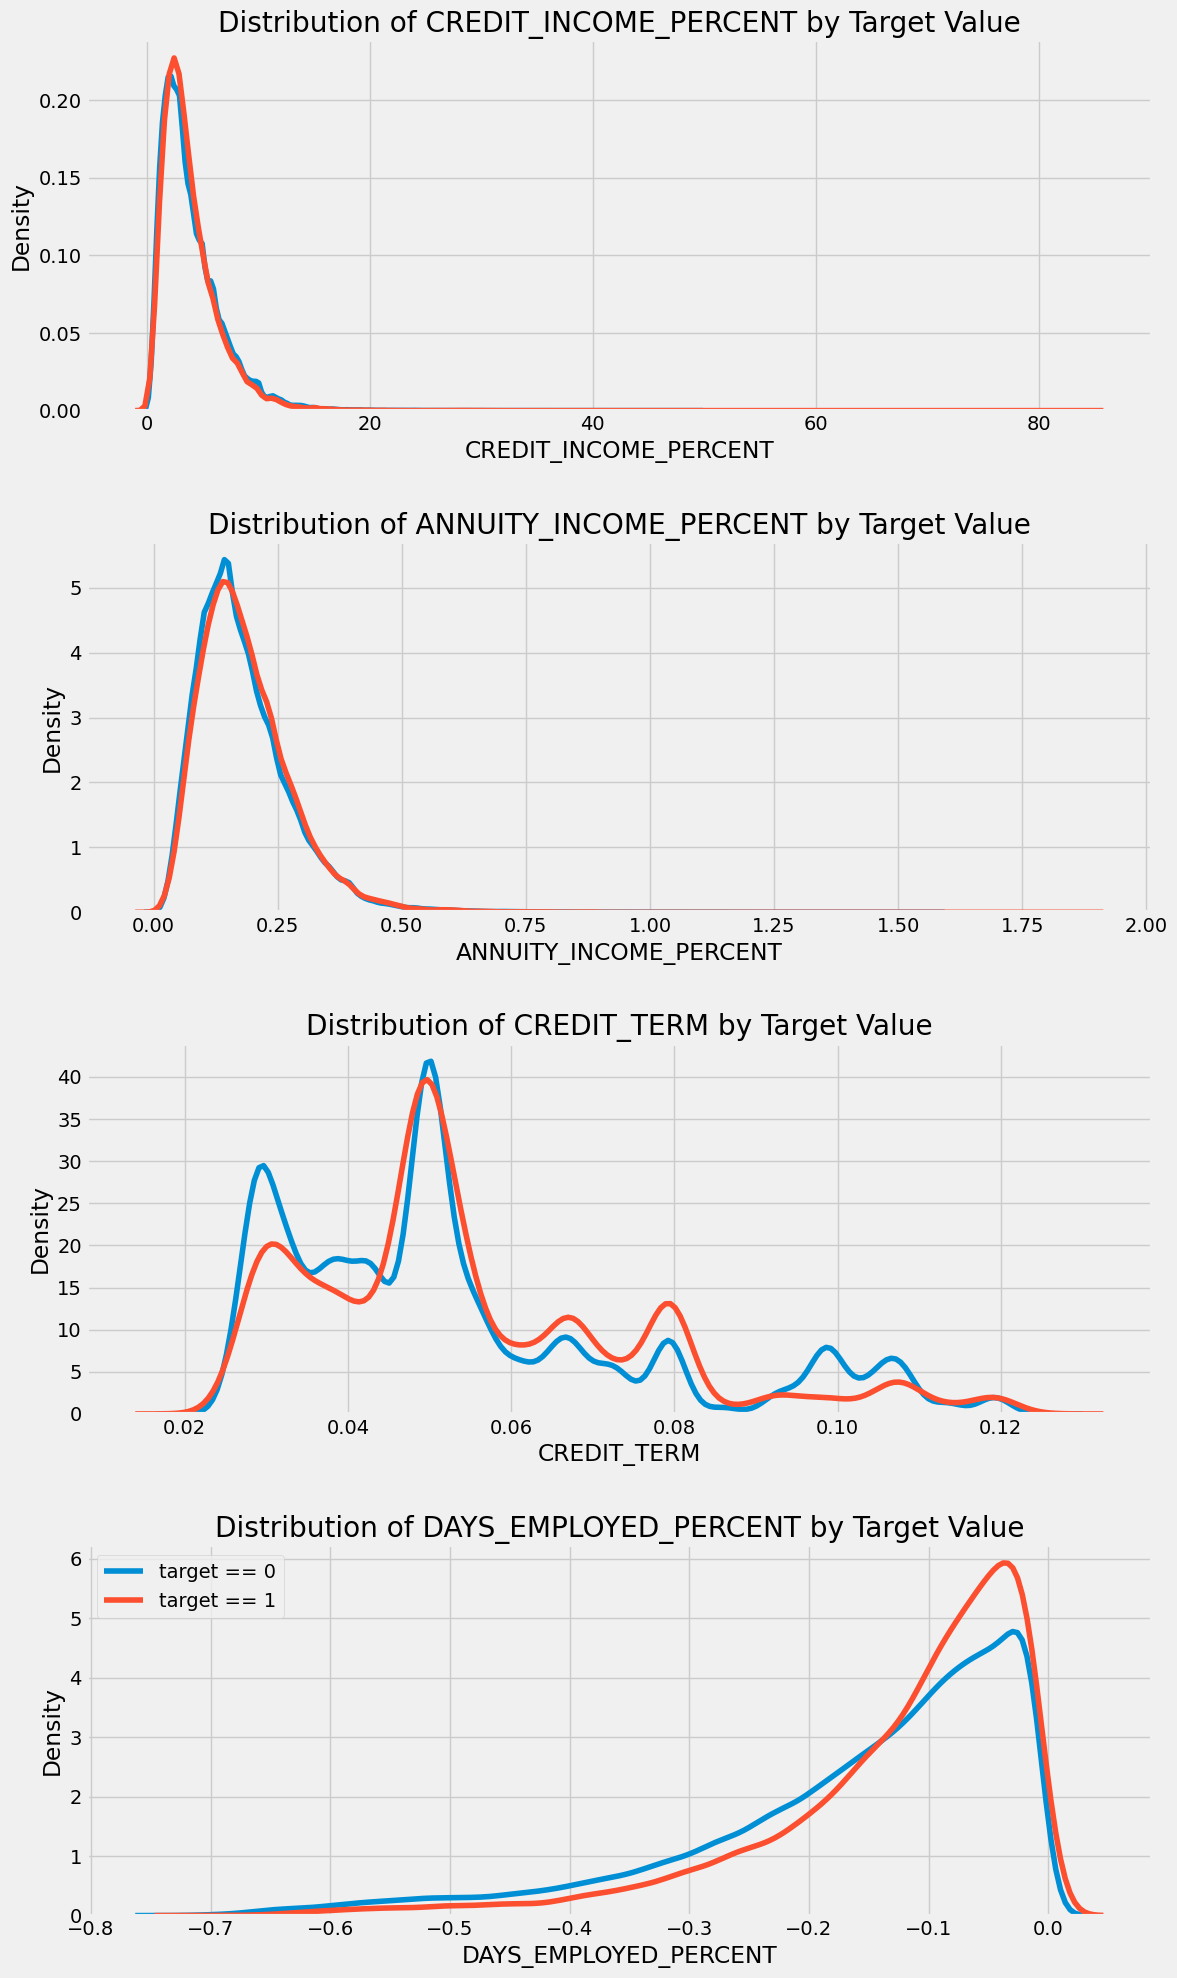

In [55]:
plt.figure(figsize = (12, 20))
# iterate through the new features
for i, feature in enumerate(['CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT']):
    
    # create a new subplot for each source
    plt.subplot(4, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 0, feature], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 1, feature], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % feature)
    plt.xlabel('%s' % feature); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)
plt.legend()

Трудно сказать, насколько сильно влияние полученных нами фичей.  

## Пайплайн подготовки датасета

In [9]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, PolynomialFeatures

# Шаг 1: Обработка аномальных значений стажа
class FeatureFlagTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        # Создание фичи-флага аномального значения
        X['DAYS_EMPLOYED_ANOM'] = X['DAYS_EMPLOYED'] > 0
        # Замена положительных значений в DAYS_EMPLOYED на np.nan
        X.loc[X['DAYS_EMPLOYED'] > 0, 'DAYS_EMPLOYED'] = np.nan
        return X

# Шаг 2: Замена np.nan на медианное значение в численных столбцах
class MedianImputer(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        self.medians = {}

    def fit(self, X, y=None):
        for col in self.columns:
            self.medians[col] = X[col].median()
        return self

    def transform(self, X):
        X = X.copy()
        for col in self.columns:
            X[col] = X[col].fillna(self.medians[col])
        return X

# Шаг 3: Замена None значений в текстовых столбцах на строку 'NONE'
class NoneReplacer(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        for col in self.columns:
            X[col] = X[col].fillna('NONE')
        return X

# Шаг 4: LabelEncoding для численных столбцов для определенных столбцов
class LabelEncoderTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        self.new_columns = [col+'_LE' for col in columns]
        self.encoder = OrdinalEncoder()

    def fit(self, X, y=None):
        self.encoder.fit(X[self.columns])
        return self

    def transform(self, X):
        X = X.copy()
        X[self.new_columns] = self.encoder.transform(X[self.columns])
        return X
    

# Шаг 5: Создание полиномиальных признаков
class PolynomialFeatureTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns, degree=3, include_bias=False):
        self.columns = columns
        self.degree = degree
        self.include_bias = include_bias
        self.poly = PolynomialFeatures(degree=self.degree, include_bias=self.include_bias)

    def fit(self, X, y=None):
        self.poly.fit(X[self.columns])
        return self

    def transform(self, X):
        X = X.copy()
        poly_features = self.poly.transform(X[self.columns])
        poly_feature_names = self.poly.get_feature_names_out(self.columns)
        poly_df = pd.DataFrame(poly_features, columns=poly_feature_names, index=X.index)
        X[poly_feature_names] = poly_df
        return X
    
# Шаг 6, создание доменных признаков
class DomenEncoderTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X['CREDIT_INCOME_PERCENT'] = X['AMT_CREDIT'] / X['AMT_INCOME_TOTAL']
        X['ANNUITY_INCOME_PERCENT'] = X['AMT_ANNUITY'] / X['AMT_INCOME_TOTAL']
        X['CREDIT_TERM'] = X['AMT_ANNUITY'] / X['AMT_CREDIT']
        X['DAYS_EMPLOYED_PERCENT'] = X['DAYS_EMPLOYED'] / X['DAYS_BIRTH']
        return X



# Определяем столбцы для обработки
columns_with_nan = app_train.select_dtypes([int, float]).columns  # Столбцы, где нужно заменить np.nan на медиану
columns_with_none = app_train.select_dtypes('object').columns  # Столбцы, где нужно заменить None на 'NONE'
columns_to_encode = app_train.select_dtypes('object').columns  # Столбцы для LabelEncoding
columns_to_polinom = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']


# Создаем пайплайн
pipeline = Pipeline(steps=[
    ('feature_flag', FeatureFlagTransformer()),  # Шаг 1
    ('median_imputer', MedianImputer(columns=columns_with_nan)),  # Шаг 2
    ('none_replacer', NoneReplacer(columns=columns_with_none)),  # Шаг 3
    ('label_encoder', LabelEncoderTransformer(columns=columns_to_encode)),  # Шаг 4
    ('polinomial_generator', PolynomialFeatureTransformer(columns_to_polinom)), # Шаг 5
    ('domen_features', DomenEncoderTransformer())# шаг 6
])

In [10]:
app_train.dtypes

SK_ID_CURR                      int64
TARGET                          int64
NAME_CONTRACT_TYPE             object
CODE_GENDER                    object
FLAG_OWN_CAR                   object
                               ...   
AMT_REQ_CREDIT_BUREAU_DAY     float64
AMT_REQ_CREDIT_BUREAU_WEEK    float64
AMT_REQ_CREDIT_BUREAU_MON     float64
AMT_REQ_CREDIT_BUREAU_QRT     float64
AMT_REQ_CREDIT_BUREAU_YEAR    float64
Length: 122, dtype: object

In [11]:
app_train_processed = pipeline.fit_transform(app_train)

display(
    app_train.head(),
    app_train_processed.head()
)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH,EXT_SOURCE_2 DAYS_BIRTH^2,EXT_SOURCE_3^3,EXT_SOURCE_3^2 DAYS_BIRTH,EXT_SOURCE_3 DAYS_BIRTH^2,DAYS_BIRTH^3,CREDIT_INCOME_PERCENT,ANNUITY_INCOME_PERCENT,CREDIT_TERM,DAYS_EMPLOYED_PERCENT
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,-346.733022,2.353667e+07,0.002707,-183.785678,1.247560e+07,-8.468590e+11,2.007889,0.121978,0.060749,0.067329
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,-5583.975307,1.748916e+08,0.153368,-4803.518937,1.504475e+08,-4.712058e+12,4.790750,0.132217,0.027598,0.070862
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,-7724.580288,2.016572e+08,0.388325,-10137.567875,2.646504e+08,-6.908939e+12,2.000000,0.100000,0.050000,0.011814
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,-6616.894625,2.349331e+08,0.153368,-5445.325225,1.933364e+08,-6.864416e+12,2.316167,0.219900,0.094941,0.159905
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,-3443.335521,1.282190e+08,0.153368,-5710.929881,2.126570e+08,-7.918677e+12,4.222222,0.179963,0.042623,0.152418


## Деление датасета на трейн и тест

In [12]:
train_set, valid_set = train_test_split(app_train_processed, train_size=0.8, stratify=app_train_processed['TARGET'])
train_set.shape, valid_set.shape

((246008, 173), (61503, 173))

# LightAutoML

## 1. Бейзлайн

In [11]:
from lightautoml.automl.presets.tabular_presets import TabularUtilizedAutoML
from lightautoml.tasks import Task
from lightautoml.report import ReportDeco

'nlp' extra dependency package 'gensim' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependency package 'nltk' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependency package 'transformers' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependency package 'gensim' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependency package 'nltk' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependency package 'transformers' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.


c:\Users\nikit\Desktop\Учеба\ИТМО\AutoML\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\nikit\Desktop\Учеба\ИТМО\AutoML\.venv\lib\site-packages\lightautoml\ml_algo\dl_model.py:42: UserWarning: 'transformers' - package isn't installed
  warnings.warn("'transformers' - package isn't installed")
c:\Users\nikit\Desktop\Учеба\ИТМО\AutoML\.venv\lib\site-packages\lightautoml\text\embed.py:22: UserWarning: 'transformers' - package isn't installed
  warnings.warn("'transformers' - package isn't installed")
c:\Users\nikit\Desktop\Учеба\ИТМО\AutoML\.venv\lib\site-packages\lightautoml\text\dl_transformers.py:25: UserWarning: 'transformers' - package isn't installed
  warnings.warn("'transformers' - package isn't installed")


In [13]:
task = Task(name = 'binary', metric = 'auc')

In [37]:
automl_model = TabularUtilizedAutoML(task = task, 
                                     cpu_limit=12, 
                                     gpu_ids=[0])
automl_model

In [38]:
oof_preds = automl_model.fit_predict(train_set, roles = {'target': 'TARGET'}, 
                                     verbose=2, 
                                     valid_data=valid_set, 
                                     log_file="./automl_log.txt")

[15:27:46] Start automl utilizator with listed constraints:
[15:27:46] - time: 3600.00 seconds
[15:27:46] - CPU: 12 cores
[15:27:46] - memory: 16 GB

[15:27:46] If one preset completes earlier, next preset configuration will be started

[15:27:46] ==================================================
[15:27:46] Start 0 automl preset configuration:
[15:27:46] c:\Users\nikit\Desktop\Учеба\ИТМО\AutoML\.venv\lib\site-packages\lightautoml\automl\presets\tabular_configs\conf_0_sel_type_0.yml, random state: {'reader_params': {'random_state': 42}, 'nn_params': {'random_state': 42}, 'general_params': {'return_all_predictions': False}}
[15:27:46] Stdout logging level is INFO2.
[15:27:46] Task: binary

[15:27:46] Start automl preset with listed constraints:
[15:27:46] - time: 3600.00 seconds
[15:27:46] - CPU: 12 cores
[15:27:46] - memory: 16 GB

[15:27:46] Train data shape: (246008, 122)

[15:28:00] Layer 1 train process start. Time left 3586.59 secs
[15:28:26] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting an

Optimization Progress:  21%|██        | 21/101 [05:07<19:30, 14.63s/it, best_trial=5, best_value=0.767]

[15:34:04] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed
[15:34:04] The set of hyperparameters {'feature_fraction': 0.8037724259507192, 'num_leaves': 56, 'bagging_fraction': 0.5325257964926398, 'min_sum_hessian_in_leaf': 6.245139574743075, 'reg_alpha': 4.905556676028774, 'reg_lambda': 0.18861495878553936}
 achieve 0.7675 auc


[15:34:55] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed
[15:34:55] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 300.00 secs


Optimization Progress:   7%|▋         | 7/101 [05:42<1:16:38, 48.92s/it, best_trial=6, best_value=0.767]

[15:40:38] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed
[15:40:38] The set of hyperparameters {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 3.4671276804481113, 'min_data_in_leaf': 20}
 achieve 0.7674 auc


[15:41:40] Time left 2766.36 secs

[15:41:40] Layer 1 training completed.

[15:41:40] Blending: optimization starts with equal weights. Score = 0.7686499
[15:41:41] Blending: iteration 0: score = 0.7687079, weights = [0.18755235 0.15442678 0.25261968 0.10883243 0.29656875]
[15:41:42] Blending: iteration 1: score = 0.7687146, weights = [0.20204575 0.15287448 0.26420298 0.08047532 0.30040148]
[15:41:43] Blending: iteration 2: score = 0.7687159, weights = [0.20155011 0.15052077 0.27435824 0.06712532 0.30644545]
[15:41:44] Blending: no improvements for score. Terminated.

[15:41:44] Blending: best score = 0.7687159, best weights = [0.20155011 0.15052077 0.27435824 0.06712532 0.30644545]
[15:41:44] Automl preset training completed in 837.63 seconds

[15:41:44] Model description:
Final prediction for new objects (level 0) = 
	 0.20155 * (1 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) +
	 0.15052 * (1 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) +
	 0.27436 * (1 averaged models Lvl_0_Pipe_1_M

c:\Users\nikit\Desktop\Учеба\ИТМО\AutoML\.venv\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


[15:42:30] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[15:42:30] Time left 2716.14 secs

[15:42:49] Selector_LightGBM fitting and predicting completed
[15:43:20] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[15:43:20] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 300.00 secs


Optimization Progress:  22%|██▏       | 22/101 [05:08<18:29, 14.04s/it, best_trial=11, best_value=0.766]

[15:48:29] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed
[15:48:29] The set of hyperparameters {'feature_fraction': 0.8446968417431815, 'num_leaves': 18, 'bagging_fraction': 0.9734809381950746, 'min_sum_hessian_in_leaf': 9.522191455192738, 'reg_alpha': 8.540823200302832, 'reg_lambda': 0.27037312810629455}
 achieve 0.7659 auc


[15:49:30] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed
[15:49:30] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 300.00 secs


Optimization Progress:   7%|▋         | 7/101 [05:14<1:10:17, 44.87s/it, best_trial=2, best_value=0.765]

[15:54:44] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed
[15:54:44] The set of hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 8.148018307012941e-07, 'min_data_in_leaf': 4}
 achieve 0.7649 auc


[15:55:57] Time left 1909.30 secs

[15:55:57] Layer 1 training completed.

[15:55:57] Blending: optimization starts with equal weights. Score = 0.7680520
[15:55:58] Blending: iteration 0: score = 0.7684550, weights = [0.3195974  0.24031936 0.3334055  0.         0.10667778]
[15:55:59] Blending: iteration 1: score = 0.7684695, weights = [0.34320855 0.1919132  0.35120788 0.         0.11367042]
[15:56:00] Blending: iteration 2: score = 0.7684703, weights = [0.3436511  0.19601378 0.34614074 0.         0.11419447]
[15:56:00] Blending: no improvements for score. Terminated.

[15:56:00] Blending: best score = 0.7684703, best weights = [0.3436511  0.19601378 0.34614074 0.         0.11419447]
[15:56:00] Automl preset training completed in 856.43 seconds

[15:56:00] Model description:
Final prediction for new objects (level 0) = 
	 0.34365 * (1 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) +
	 0.19601 * (1 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) +
	 0.34614 * (1 averaged models Lvl_0_Pipe_1_M

Optimization Progress:  19%|█▉        | 19/101 [05:06<22:01, 16.12s/it, best_trial=11, best_value=0.762]

[16:02:20] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed
[16:02:20] The set of hyperparameters {'feature_fraction': 0.8446968417431815, 'num_leaves': 18, 'bagging_fraction': 0.9734809381950746, 'min_sum_hessian_in_leaf': 9.522191455192738, 'reg_alpha': 8.540823200302832, 'reg_lambda': 0.27037312810629455}
 achieve 0.7619 auc


[16:03:27] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed
[16:03:27] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 300.00 secs


Optimization Progress:   7%|▋         | 7/101 [05:53<1:19:07, 50.51s/it, best_trial=6, best_value=0.761]

[16:09:21] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed
[16:09:21] The set of hyperparameters {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 3.4671276804481113, 'min_data_in_leaf': 20}
 achieve 0.7606 auc


[16:10:53] Time left 1013.17 secs

[16:10:53] Layer 1 training completed.

[16:10:53] Blending: optimization starts with equal weights. Score = 0.7630962
[16:10:54] Blending: iteration 0: score = 0.7632481, weights = [0.18724127 0.0973199  0.3252506  0.10392379 0.2862644 ]
[16:10:56] Blending: iteration 1: score = 0.7632561, weights = [0.19713746 0.08316237 0.32638416 0.07155464 0.32176137]
[16:10:57] Blending: no improvements for score. Terminated.

[16:10:57] Blending: best score = 0.7632561, best weights = [0.19713746 0.08316237 0.32638416 0.07155464 0.32176137]
[16:10:57] Automl preset training completed in 896.30 seconds

[16:10:57] Model description:
Final prediction for new objects (level 0) = 
	 0.19714 * (1 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) +
	 0.08316 * (1 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) +
	 0.32638 * (1 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) +
	 0.07155 * (1 averaged models Lvl_0_Pipe_1_Mod_2_CatBoost) +
	 0.32176 * (1 averaged models Lvl_

Optimization Progress:  11%|█         | 11/101 [02:38<21:37, 14.42s/it, best_trial=5, best_value=0.764]

[16:15:03] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed
[16:15:03] The set of hyperparameters {'feature_fraction': 0.8037724259507192, 'num_leaves': 56, 'bagging_fraction': 0.5325257964926398, 'min_sum_hessian_in_leaf': 6.245139574743075, 'reg_alpha': 4.905556676028774, 'reg_lambda': 0.18861495878553936}
 achieve 0.7639 auc


[16:15:38] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed
[16:15:38] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 300.00 secs


Optimization Progress:   7%|▋         | 7/101 [05:15<1:10:42, 45.13s/it, best_trial=0, best_value=0.765]

[16:20:54] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed
[16:20:54] The set of hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0024430162614261413, 'min_data_in_leaf': 4}
 achieve 0.7646 auc


[16:21:55] Time left 351.17 secs

[16:21:55] Layer 1 training completed.

[16:21:55] Blending: optimization starts with equal weights. Score = 0.7665492
[16:21:56] Blending: iteration 0: score = 0.7672236, weights = [0.33357224 0.09592167 0.36410764 0.         0.20639841]
[16:21:57] Blending: iteration 1: score = 0.7672567, weights = [0.37996152 0.         0.38397053 0.         0.23606798]
[16:21:59] Blending: iteration 2: score = 0.7672615, weights = [0.36275458 0.05701343 0.35053816 0.         0.2296938 ]
[16:22:00] Blending: iteration 3: score = 0.7672621, weights = [0.36336032 0.05596986 0.35263494 0.         0.22803485]
[16:22:01] Blending: iteration 4: score = 0.7672622, weights = [0.3672126  0.05578747 0.35742065 0.         0.21957931]
[16:22:01] Blending: best score = 0.7672622, best weights = [0.3672126  0.05578747 0.35742065 0.         0.21957931]
[16:22:01] Automl preset training completed in 663.94 seconds

[16:22:01] Model description:
Final prediction for new objects (lev

Best score – **0.7693**

c:\Users\nikit\Desktop\Учеба\ИТМО\AutoML\.venv\lib\site-packages\lightautoml\automl\presets\tabular_presets.py:1059: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  pd.concat(feat_imps).groupby("Feature")["Importance"].agg(sum).sort_values(ascending=False)


<Axes: title={'center': 'Feature importance'}, xlabel='Feature', ylabel='Importance'>

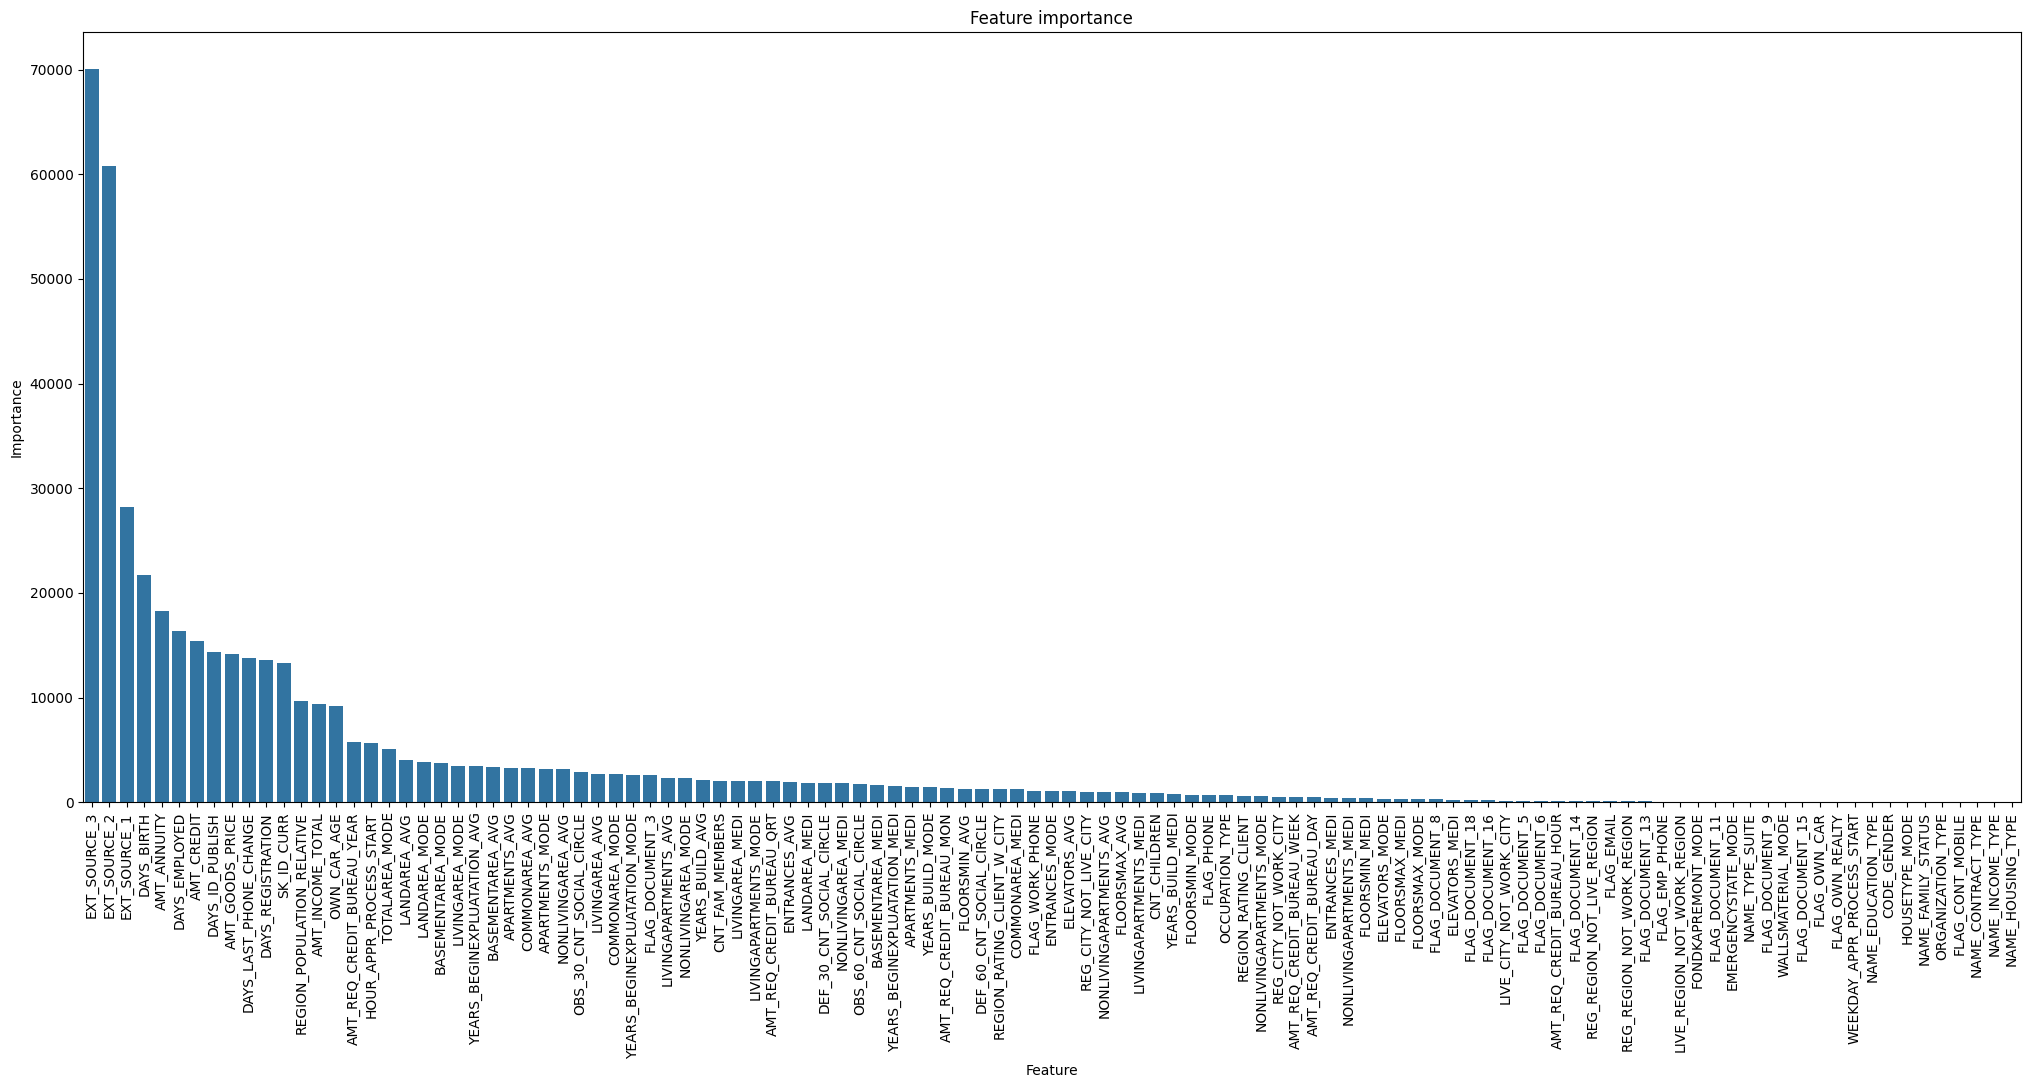

In [44]:
model_fi = automl_model.get_feature_scores()

plt.figure(figsize=(25, 10))
plt.title('Feature importance')
plt.xticks(rotation=90)
sns.barplot(model_fi, x='Feature', y='Importance')

In [40]:
rdu = ReportDeco(output_path = 'tabularUtilizedAutoML_model_report')

rdu(automl_model)

## 2. Использование связей между таблицами

Использование связей между таблицами для генерации агрегатов в качестве доп. фичей 

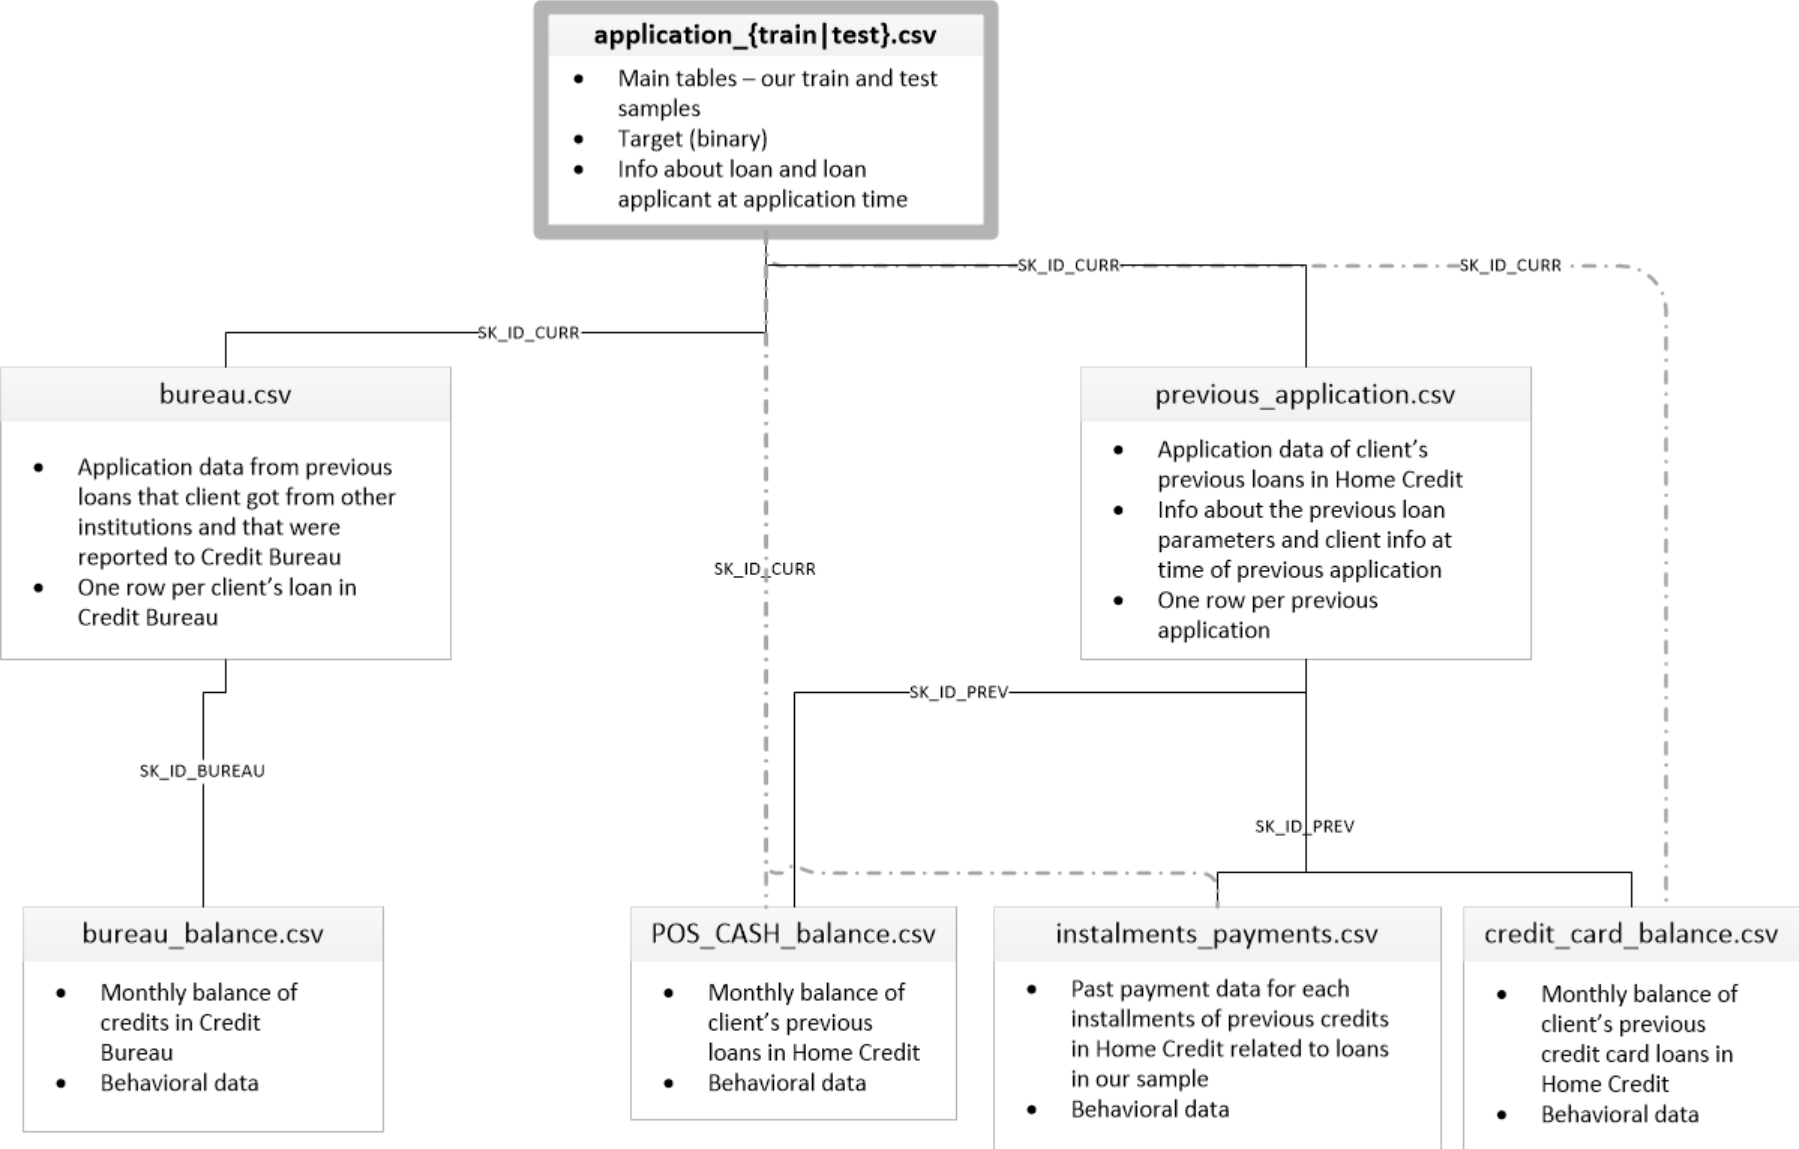

In [221]:
from lightautoml.reader.base import DictToPandasSeqReader, PandasToPandasReader
from lightautoml.tasks import Task
from lightautoml.report import ReportDeco
from lightautoml.pipelines.features.generator_pipeline import FeatureGeneratorPipeline
from lightautoml.automl.base import AutoML
from lightautoml.ml_algo.boost_lgbm import BoostLGBM
from lightautoml.ml_algo.boost_cb import BoostCB
from lightautoml.ml_algo.linear_sklearn import LinearLBFGS
from lightautoml.pipelines.features.lgb_pipeline import LGBSimpleFeatures
from lightautoml.pipelines.features.linear_pipeline import LinearFeatures
from lightautoml.pipelines.ml.nested_ml_pipe import MLPipeline
from lightautoml.automl.blend import BestModelSelector, Blender
from lightautoml.utils.timer import PipelineTimer
from lightautoml.ml_algo.tuning.optuna import OptunaTuner
from lightautoml.pipelines.selection.importance_based import ImportanceCutoffSelector, ModelBasedImportanceEstimator

Указываем связи между таблицами

In [209]:
seq_params = {
    "credit_card_balance": {
      "case": "ids",
      "params": {},
      "scheme": 
        {
          "to": "plain",
          "from_id": "SK_ID_CURR",
          "to_id": "SK_ID_CURR"
        }
    },
    "bureau": {
      "case": "ids",
      "params": {},
      "scheme": 
        {
          "to": "plain",
          "from_id": "SK_ID_CURR",
          "to_id": "SK_ID_CURR"
        }
      
    },
    "previous_application": {
      "case": "ids",
      "params": {},
      "scheme": 
        {
          "to": "plain",
          "from_id": "SK_ID_CURR",
          "to_id": "SK_ID_CURR"
        }
      
    }
  }

print(*seq_params.keys())

credit_card_balance bureau previous_application


In [210]:
seq_data = {
    'bureau': bureau,
    'previous_application': previous_application,
    'credit_card_balance': credic_card_balance
}

In [261]:
train_param = {
    'plain': train_set,
    'seq': seq_data
}

valid_param = {
    'plain': valid_set,
    'seq': seq_data
}

test_param = {
    'plain': app_test,
    'seq': seq_data
}

Первый уровень

In [262]:
generator1 = FeatureGeneratorPipeline(
    seq_params,
    max_gener_features=100,
    per_top_categories=25,
    sample_size = None,
    n_jobs=1,
)
feats_LGB = generator1.append(LGBSimpleFeatures())

params_tuner1 = OptunaTuner(n_trials=20, timeout=120)
params_tuner2 = OptunaTuner(n_trials=20, timeout=120)
model1 = BoostLGBM()
model2 = BoostCB()

pipeline_lvl1 = MLPipeline(
    [
        (model1, params_tuner1),
        (model2, params_tuner2),
    ], 
    pre_selection=None, 
    features_pipeline=feats_LGB,
    post_selection=None)
pipeline_lvl1

Второй уровень

In [264]:
model1_2 = BoostCB()
model2_2 = LinearLBFGS()

pipeline_lvl2 = MLPipeline(
    [
        model1_2,
        model2_2
    ], 
    pre_selection=None, 
    features_pipeline=None,
    post_selection=None)
pipeline_lvl2

Обучение

In [265]:
task = Task('binary', metric='auc')
roles={'target': 'TARGET'}
reader = DictToPandasSeqReader(task=task, seq_params=seq_params)

In [266]:
timer = PipelineTimer()
automl = AutoML(reader, [[pipeline_lvl1], [pipeline_lvl2]], skip_conn=False, timer=None, debug=True)
automl

In [267]:
import warnings
warnings.filterwarnings("ignore")

In [268]:
oof_preds = automl.fit_predict(train_data=train_param,
                               #valid_data=valid_set,
                               roles=roles,
                               verbose=2)

oof_preds

[00:36:46] Layer 1 train process start. Time left 9999999962.04 secs
[00:36:46] This selector only for holdout training. fit_on_holout argument added just to be compatible
[00:48:09] LightGBM fitting and predicting completed
[00:48:13] LightGBM fitting and predicting completed
[00:48:19] LightGBM fitting and predicting completed
[00:48:26] LightGBM fitting and predicting completed
[00:48:34] LightGBM fitting and predicting completed
[00:48:42] LightGBM fitting and predicting completed
[00:48:51] LightGBM fitting and predicting completed
[00:49:02] LightGBM fitting and predicting completed
[00:58:34] Start hyperparameters optimization for Lvl_0_Pipe_0_Mod_0_LightGBM ... Time budget is 120.00 secs


Optimization Progress:   0%|          | 0/20 [00:00<?, ?it/s]

[00:59:07] Lvl_0_Pipe_0_Mod_0_LightGBM fitting and predicting completed


Optimization Progress:   5%|▌         | 1/20 [00:32<10:22, 32.76s/it, best_trial=0, best_value=0.762]

[00:59:32] Lvl_0_Pipe_0_Mod_0_LightGBM fitting and predicting completed


Optimization Progress:  10%|█         | 2/20 [00:58<08:31, 28.44s/it, best_trial=1, best_value=0.764]

[00:59:53] Lvl_0_Pipe_0_Mod_0_LightGBM fitting and predicting completed


Optimization Progress:  15%|█▌        | 3/20 [01:18<07:02, 24.87s/it, best_trial=2, best_value=0.767]

[01:00:25] Lvl_0_Pipe_0_Mod_0_LightGBM fitting and predicting completed


Optimization Progress:  20%|██        | 4/20 [01:50<07:23, 27.73s/it, best_trial=2, best_value=0.767]

[01:00:52] Lvl_0_Pipe_0_Mod_0_LightGBM fitting and predicting completed


Optimization Progress:  25%|██▌       | 5/20 [02:18<06:55, 27.67s/it, best_trial=2, best_value=0.767]

[01:00:52] Hyperparameters optimization for Lvl_0_Pipe_0_Mod_0_LightGBM completed
[01:00:52] The set of hyperparameters {'feature_fraction': 0.5780093202212182, 'num_leaves': 53}
 achieve 0.7667 auc
[01:00:52] Start fitting Lvl_0_Pipe_0_Mod_0_LightGBM ...


[01:00:52] ===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LightGBM =====
[01:01:14] ===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_0_LightGBM =====
[01:01:41] ===== Start working with fold 2 for Lvl_0_Pipe_0_Mod_0_LightGBM =====
[01:02:08] ===== Start working with fold 3 for Lvl_0_Pipe_0_Mod_0_LightGBM =====
[01:02:37] ===== Start working with fold 4 for Lvl_0_Pipe_0_Mod_0_LightGBM =====
[01:03:01] Fitting Lvl_0_Pipe_0_Mod_0_LightGBM finished. score = 0.7620375760174236
[01:03:01] Lvl_0_Pipe_0_Mod_0_LightGBM fitting and predicting completed
[01:03:01] Start hyperparameters optimization for Lvl_0_Pipe_0_Mod_1_CatBoost ... Time budget is 120.00 secs


Optimization Progress:   0%|          | 0/20 [00:00<?, ?it/s]

[01:05:13] Lvl_0_Pipe_0_Mod_1_CatBoost fitting and predicting completed


Optimization Progress:   5%|▌         | 1/20 [02:12<41:50, 132.12s/it, best_trial=0, best_value=0.769]

[01:05:13] Hyperparameters optimization for Lvl_0_Pipe_0_Mod_1_CatBoost completed
[01:05:13] The set of hyperparameters {'max_depth': 4, 'nan_mode': 'Max'}
 achieve 0.7686 auc
[01:05:13] Start fitting Lvl_0_Pipe_0_Mod_1_CatBoost ...


[01:05:13] ===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_1_CatBoost =====
[01:07:26] ===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_1_CatBoost =====
[01:09:38] ===== Start working with fold 2 for Lvl_0_Pipe_0_Mod_1_CatBoost =====
[01:11:18] ===== Start working with fold 3 for Lvl_0_Pipe_0_Mod_1_CatBoost =====
[01:12:57] ===== Start working with fold 4 for Lvl_0_Pipe_0_Mod_1_CatBoost =====
[01:15:01] Fitting Lvl_0_Pipe_0_Mod_1_CatBoost finished. score = 0.7651102692715681
[01:15:01] Lvl_0_Pipe_0_Mod_1_CatBoost fitting and predicting completed
[01:15:01] Time left 9999997666.45 secs

[01:15:01] Layer 1 training completed.

[01:15:01] Layer 2 train process start. Time left 9999997666.45 secs
[01:15:01] Start fitting Lvl_1_Pipe_0_Mod_0_CatBoost ...
[01:15:01] ===== Start working with fold 0 for Lvl_1_Pipe_0_Mod_0_CatBoost =====
[01:15:05] ===== Start working with fold 1 for Lvl_1_Pipe_0_Mod_0_CatBoost =====
[01:15:13] ===== Start working with fold 2 for Lvl_1_Pipe_0_Mod_0_CatB

array([[0.15277201],
       [0.05379041],
       [0.07085154],
       ...,
       [0.04414581],
       [0.0437129 ],
       [0.0616918 ]], dtype=float32)

Расчет метрики

In [269]:
from sklearn.metrics import roc_auc_score

pred = automl.predict(valid_param)
pred

array([[0.05837044],
       [0.08754338],
       [0.05768251],
       ...,
       [0.0652401 ],
       [0.11617212],
       [0.06129011]], dtype=float32)

In [270]:
roc_auc_score(valid_param['plain']['TARGET'], pred.data)

0.7530890024789537

**Best score** – 0.753

# Решение без использования LAML

На основании сгенерированных фичей построим модели и выберем ту, которая даст лучший ROC-AUC скор

### Логистическая регрессия

In [271]:
# отбросим все нечисленные фичи
train_set_num: pd.DataFrame = train_set.select_dtypes([int, float])
valid_set_num: pd.DataFrame = valid_set.select_dtypes([int, float])

train_y = train_set_num['TARGET']
valid_y = valid_set_num['TARGET']

imputer = SimpleImputer()
train_set_num = train_set_num.drop(columns='TARGET')
valid_set_num = valid_set_num.drop(columns='TARGET')

In [274]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(train_set_num, train_y)
log_reg_pred = log_reg.predict_proba(valid_set_num)[:, 1]
log_reg_score = roc_auc_score(valid_y, log_reg_pred)
log_reg_score

0.6822462640157854

### Случайный лес

In [275]:
# отбросим все нечисленные фичи
train_set_num: pd.DataFrame = train_set.select_dtypes([int, float])
valid_set_num: pd.DataFrame = valid_set.select_dtypes([int, float])

train_y = train_set_num['TARGET']
valid_y = valid_set_num['TARGET']

imputer = SimpleImputer()
train_set_num = train_set_num.drop(columns='TARGET')
valid_set_num = valid_set_num.drop(columns='TARGET')

In [276]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier()
random_forest.fit(train_set_num, train_y)
random_forest_pred = random_forest.predict_proba(valid_set_num)[:, 1]
random_forest_score = roc_auc_score(valid_y, random_forest_pred)
random_forest_score

0.7054330773513572

### CatBoost

In [13]:
# отбросим все нечисленные фичи
train_set_cb = train_set.copy()
valid_set_cb = valid_set.copy()

train_y = train_set_cb['TARGET']
valid_y = valid_set_cb['TARGET']

train_set_cb = train_set_cb.drop(columns='TARGET')
valid_set_cb = valid_set_cb.drop(columns='TARGET')

In [14]:
class_weights = train_y.value_counts()
class_weights /= class_weights.sum()
class_weights = 1 - class_weights
class_weights

TARGET
0    0.080729
1    0.919271
Name: count, dtype: float64

In [15]:
cat_cols = train_set_cb.select_dtypes('object').columns.tolist()
cat_cols

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'ORGANIZATION_TYPE',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'WALLSMATERIAL_MODE',
 'EMERGENCYSTATE_MODE']

In [16]:
from catboost import CatBoostClassifier
from catboost import Pool

train_pool = Pool(train_set_cb, cat_features=cat_cols, label=train_y)
valid_pool = Pool(valid_set_cb, cat_features=cat_cols, label=valid_y)

In [17]:
def objective(trial):
    param = {
        "objective": trial.suggest_categorical("objective", ["Logloss"]),
        #"colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        "used_ram_limit": "8gb",
        "iterations": trial.suggest_int("iterations", 30, 100)
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    gbm = CatBoostClassifier(task_type='GPU', eval_metric='AUC', class_weights=1/class_weights, **param)

    gbm.fit(train_pool, verbose=0, early_stopping_rounds=100)

    preds = gbm.predict_proba(valid_pool)[:, 1]
    accuracy = roc_auc_score(valid_y, preds)
    del gbm
    return accuracy

In [18]:
import optuna 
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=15, timeout=1200)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

c:\Users\nikit\Desktop\Учеба\ИТМО\AutoML\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-01-21 21:58:52,077] A new study created in memory with name: no-name-01eeaf09-c4ec-48e3-bce0-47c1393d4d84
Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-01-21 21:58:57,131] Trial 0 finished with value: 0.7166740586062179 and parameters: {'objective': 'Logloss', 'depth': 1, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'iterations': 93}. Best is trial 0 with value: 0.7166740586062179.
Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-01-21 21:59:01,806] Trial 1 finished with value: 0.7305531500581184 and parameters: {'objective': 'Logloss', 'depth': 4, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'iterations': 38, 'bagging_temperature': 4

Number of finished trials: 15
Best trial:
  Value: 0.7505704030231499
  Params: 
    objective: Logloss
    depth: 10
    boosting_type: Ordered
    bootstrap_type: Bernoulli
    iterations: 49
    subsample: 0.5814055941713215


In [19]:
cb_model = CatBoostClassifier(eval_metric='AUC', class_weights=class_weights, task_type='GPU', **trial.params)
cb_model.fit(train_pool, metric_period=50)
cb_pred = cb_model.predict_proba(valid_pool)

Learning rate set to 0.371412
0:	total: 498ms	remaining: 23.9s
48:	total: 20.4s	remaining: 0us


In [20]:
cb_score = roc_auc_score(valid_y, cb_pred[:, 1])
cb_score

0.7542550800525678

In [21]:
fi = pd.Series(cb_model.feature_importances_, index=cb_model.feature_names_).sort_values(ascending=False).to_frame()
fi

,0
CREDIT_TERM,9.668452
EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3,7.348166
AMT_ANNUITY,4.552164
EXT_SOURCE_2 EXT_SOURCE_3,3.672405
AMT_GOODS_PRICE,3.343497
...,...
REG_REGION_NOT_WORK_REGION,0.000000
FLOORSMIN_AVG,0.000000
REG_REGION_NOT_LIVE_REGION,0.000000
FLAG_EMAIL,0.000000


Best score – **0.754**

# Выводы

Было реализовано 5 пайплайнов. Вот скоры, полученные на каждом:

1. LAMA TabularAutoML (дефолтный) – **0.7693**
2. LAMA кастомная сборка + агрегаты из других таблиц – 0.753
3. Логистическая регрессия - 0.68
4. Случайный лес – 0.70
5. CatBoost + Optuna – 0.754

Лучшим решением оказался дефолтный LAMA TabularAutoML.